In [ ]:
import math
import random
import requests
import time

import numpy as np
import torch
import torchvision

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch.nn.functional as F

from io import BytesIO
from PIL import Image

# Lakota AI Code Camp Lesson 17: Object Detection Loss

The loss functions for object detection were particularly complex, about 10 years ago.
We'll go over the loss functions for SSD.
Then we'll go over the the various IoU-based losses, which are still used in modern state of the art transformer-based models.


## SSD Loss

SSD stands for single shot detector.
It was developed to unify the object detection pipeline into one neural network.

The model takes in an image and gives $(c + 4)kmn$ output for an $m \times n$ image.
In the original paper, they used 4 different default boxes (they can be thought of as anchor boxes, even though they're technically not).

We define auxiliary variables $x_{ij}^{p}$, which is 0 or 1, $x = \{x_{ij}^{p}\}$.
The auxiliary variables are indexed over the default boxes, index $i$, the ground truth boxes, index $j$, and the categories $p$.
It's 1 if the $i$th default box prediction is assigned to the $j$th object of category $p$ and it's 0, otherwise.

The actual loss used is composed of a localization loss and a confidence loss.
The localization loss ensures that we have the right location for our bounding box and the confidence loss is to ensure we get the correct category for our bounding box.
Mathematically, the loss is:
$$
L(x, c, l, g) = \frac{1}{N}\left(L_{conf}(x, c) + \alpha L_{loc}(x, l, g)\right),
$$
where $N$ is the number of matched default boxes, $x$ is the variable above, $c$ is the confidence in the prediction, $l$ is the predicted bounding box coordinates, and $g$ is the ground truth bounding box coordinates.
Finally, $\alpha$ above is a hyper parameter.

Let's look at the $\operatorname{smooth}_{L1}$ function before we go further into the loss of the location function.

The $\operatorname{smooth}_{L1}$ was defined in a paper by R. Girshick, *Fast R-CNN*.
Mathematically, it's defined as:
$$
\operatorname{smooth}_{L1} =
\begin{cases}
0.5 x^{2} & \textrm{if } |x| < 1 \\
|x| - 0.5 & \textrm{otherwise}
\end{cases}.
$$
Let's look at a graph of the function.

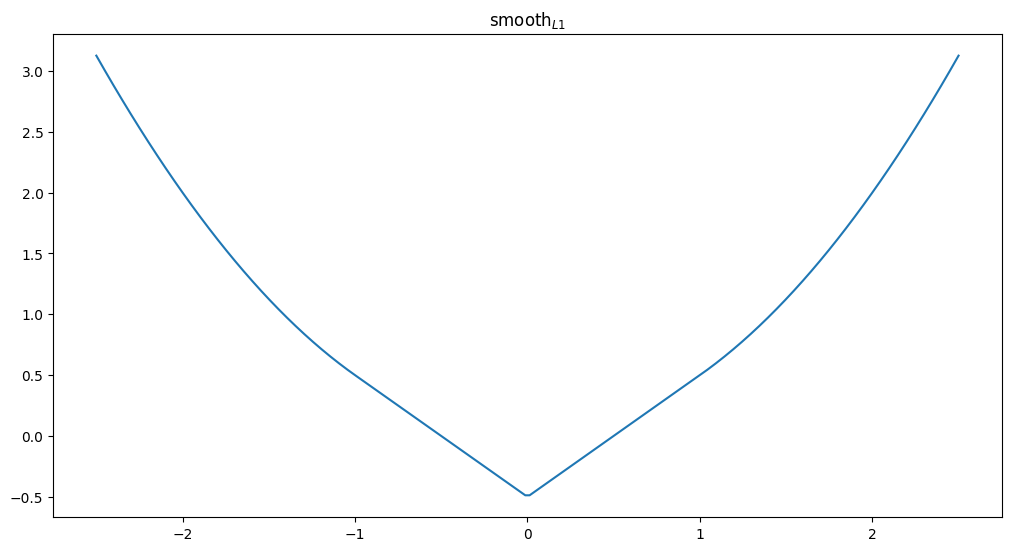

In [ ]:
x = torch.linspace(-2.5, 2.5, 200)
y = torch.where(torch.abs(x) > 1, 0.5 * torch.square(x), torch.abs(x) - 0.5)

fig, ax = plt.subplots(figsize=(10, 5.4), layout='constrained')
ax.plot(x, y)
ax.set_title("$\operatorname{smooth}_{L1}$")
plt.show()

Now, we can return to the localization loss.

The bounding box predictions are in a different format than mentioned before.
They are $(cx, cy, w, h)$, where $(cx, cy)$ is the coordinates for the center of the bounding box.
If $l_{i}$ is the predicted grounding box, then the loss is summed over all positive examples and over a special loss function.
$$
L_{loc}(x, l, g) = \sum_{i \in Pos} \sum_{m \in (cx, cy, w, h)} x_{ij}^{k} \operatorname{smooth}_{L1}(l_{i}^{m} - \widehat{g}_{j}^{m}).
$$
The $\widehat{g}_{j}^{m}$ are defined based on the default boxes and the ground truth boxes.
$$
\widehat{g}_{j}^{cx} = \frac{g_{j}^{cx} - d_{i}^{cx}}{d_{i}^{w}}
$$
$$
\widehat{g}_{j}^{cy} = \frac{g_{j}^{cy} - d_{i}^{cy}}{d_{i}^{h}}
$$
$$
\widehat{g}_{j}^{w} = \log \left(\frac{g_{j}^{w}}{d_{i}^{w}}\right)
$$
$$
\widehat{g}_{j}^{h} = \log \left(\frac{g_{j}^{h}}{d_{i}^{h}}\right).
$$
Finally, a default box is classified as positive if:
1.  if that anchor box has the highest IoU with the ground truth box;
1.  if the IoU of the anchor box and any ground truth box is $> 0.7$.
A negative label is applied if:
1.  the IoU of the anchor box and any ground truth box is $< 0.3$.

The first two formulas come from the fact that we're trying to get the offset to the center of a default box and we're normalizing on the size of the default box.
The second two formulas come from the fact that our predicted width is $l_{i}^{w}$, but to transform that into an actual box we can use, we have to use the following formula:
$$
d_{i}^{w} e^{l_{i}^{w}}.
$$
A similar formula holds for the height.

The confidence loss, $L_{conf}$, is simpler than $L_{loc}$.
It's very similar to the cross entropy loss:
$$
L_{conf}(x, c) = -\sum_{i \in Pos} x_{ij} \log(\widehat{c}_{i}^{p}) - \sum_{i \in Neg} \log(\widehat{c}_{i}^{p})
$$
where $x$ is defined above and $c$ are the confidence predictions.
Further, $\widehat{c}_{i}^{p}$ is defined as:
$$
\widehat{c}_{i}^{p} = \frac{\exp(c_{i}^{p})}{\sum_{p} \exp(c_{i}^{p})}
$$
that is we take the softmax over all the predictions.

## IoU Loss

We're going to go over the various IoU loss functions, as they are still used in state of the art object detection models, such as DINO (**D**ETR with **I**mproved de**N**oising anch**O**r boxes).
They are also much simpler than the loss function above, which is similar in complexity to early versions of the YOLO models.

Recall that IoU is defined by:
$$
\operatorname{IoU}({\bf B}, {\bf \widehat{B}}) = \frac{{\bf B} \cap {\bf \widehat{B}}}{{\bf B} \cup {\bf \widehat{B}}},
$$
where ${\bf B}$ is the ground truth bounding box and ${\bf \widehat{B}}$ is predicted bounding box.
So, the IoU loss is defined as:
$$
\mathcal{L}_{\operatorname{IoU}}({\bf B}, {\bf \widehat{B}}) = 1 - \operatorname{IoU}({\bf B}, {\bf \widehat{B}}).
$$

Experimental evidence, shows that this loss doesn't train very well.
This led Zheng et al. to propose a more generalized method of creating IoU-based loss functions in their paper *Distance-IoU Loss: Faster and Better Learning for Bounding Box Regression*.
The general formula for an IoU-based loss is:
$$
\mathcal{L} = 1 - \operatorname{IoU}({\bf B}, {\bf \widehat{B}}) + \mathcal{R}({\bf B}, {\bf \widehat{B}}),
$$
where $\mathcal{R}$ can be thought of as a penalty term.

A general method for making these loss functions is as follows, given that we have a PyTorch enabled method of calculating the IoU:

In [ ]:
class GeneralizedIoULoss(torch.nn.Module):

    def __init__(self, regression_func):
        super(GeneralizedIoULoss).__init()
        self.regression = regression_func

    def forward(self, input, target):
        loss = 1 - IoU(input, target) + self.regression(input, target)
        return loss

### Distance-IoU Loss

For distnace IoU loss, the loss is penalized, based on how far the prediction is from the ground truth.
So, the regression is
$$
\mathcal{R}_{\operatorname{DIoU}} = \frac{\left\lVert {\bf b} - {\bf \widehat{b}} \right\rVert}{c^{2}}
$$
where ${\bf b} = (cx, cy)$ are the coordinates of the center of the ground truth bounding box, ${\bf \widehat{b}} = (\widehat{cx}, \widehat{cy})$ is the center of the predicted bounding box and $c$ is the diagonal of the smallest enclosing bounding box.
We can calculate $c^{2}$ in the following manner:

In [ ]:
def enclosing_box_diag(input, target):
    # input and target are assumed to be in bl-tr format

    x1, y1, x2, y2, = input
    x1_hat, y1_hat, x2_hat, y2_hat = target

    # Calculate the enclosing box coordss
    x_bl = min(x1, x1_hat)
    y_bl = min(y1, y1_hat)
    x_tr = max(x2, x2_hat)
    y_tr = max(y2, y2_hat)

    # calculating the diagonal squared
    c_squared = (x_tr - x_bl) ** 2 + (y_tr - y_bl) ** 2

    return c_squared

### Complete IoU Loss

This loss is related to the DIoU loss, but there's an additional term added to $\mathcal{R}_{\operatorname{DIoU}}$:
$$
\mathcal{R}_{\operatorname{CIoU}} = \mathcal{R}_{\operatorname{DIoU}} + \alpha v
$$
where
$$
v = \frac{4}{\pi^{2}}\left(\arctan\frac{\widehat{w}}{\widehat{h}} - \arctan \frac{w}{h}\right)^{2}
$$
here, $\widehat{w}$ and $\widehat{h}$ are the predicted width and height and $w$ and $h$ are the actual width and height.
$$
\alpha = \frac{v}{1 - \operatorname{IoU} + v}
$$

The arc tangent term is trying to get the angle of the diagonal of the bounding boxes.
So, we're estimating how far apart the angles are.